# Exploring Delahaye mQTLs: Replication and Cleaning
Three major steps:
1. Load in data and assess replication between Placental Regulation (Delahaye) dataset, RICHS, and Placental data from the Robinson Lab
1. Assess effect of genotype dosage on number of significant mQTLs, repeating for sex-stratified dosage filters
1. Assess effect sizes of sex-specific hits in terms of differences in allelic fold-change (aFC)
1. Assess hits that stand-up to "fine mapping"


In [2]:
import pandas as pd
import time
import sys
%load_ext rpy2.ipython

### Loading in marginal data 
This is slightly faster in python, I have saved large datasets as a parquet file, which can be read using `pandas` and `pyarrow` in python, and the `arrow` library in R.

In [ ]:
t = time.time()
delahaye = pd.read_parquet("../../delahaye_QC/matrix_eqtl_data/cis_mQTL_9_methy_PC_all.parquet")
print(time.time() - t)

Just checking that enrichment is what I would expect for cis-mQTL analysis (mostly uniform other than many hits due to enrichment of signal in *cis*).

Matplotlib created a temporary config/cache directory at /tmp/pbs.2114370.pbsha.ib.sockeye/matplotlib-ngq1197w because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


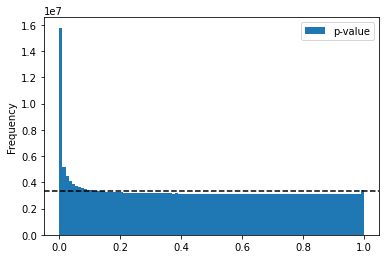

In [4]:
bins = 100
plt = delahaye[['p-value']].plot(kind='hist', bins=bins)
plt.axhline(y=len(delahaye) / 100.0, linestyle='--', color='black')

Loading in remaining data:

In [6]:
richs = pd.read_parquet("../../RICHS_QC/matrix_eqtl_data/cis_mQTL_9_methy_PC_all.parquet")
robinson = pd.read_parquet("../../robinson_results/cis_impute_mQTL_results_6_methy_PC.parquet")

### Replication of marginal signals

In [ ]:
def run_replication(df1,df2):
    return df2.merge(df1[df1['FDR'] < 0.05], on=['SNP','gene'])

delahaye_richs = run_replication(delahaye, richs)
richs_delahaye = run_replication(richs, delahaye)
delahaye_robinson = run_replication(delahaye, robinson)
robinson_delahaye = run_replication(robinson,delahaye)

In [ ]:
%R library(qvalue); print(1 - pi0est(delahaye_richs$`p-value`))
%R library(qvalue); print(1 - pi0est(richs_delahaye$`p-value`))
%R library(qvalue); print(1 - pi0est(delahaye_robinson$`p-value`))
%R library(qvalue); print(1 - pi0est(robinson_delahaye$`p-value`))

## Loading in sex-specific signals

In [ ]:
delahaye_sex = pd.read_parquet("../../delahaye_QC/matrix_eqtl_data/cis_mQTL_9_methy_PC_all_sex_interaction.parquet")
richs_sex = pd.read_csv("../../RICHS_QC/matrix_eqtl_data/cis_mQTL_9_methy_PC_all_sex_interaction.txt", sep="\s+")
robinson_sex = pd.read_csv("../../robinson_results/cis_int_sex_all_chr_impute_mQTL_results_6_methy_PC.txt", sep="\s+")
richs_sex.to_parquet("../../RICHS_QC/matrix_eqtl_data/cis_mQTL_9_methy_PC_all_sex_interaction.parquet")
robinson_sex.to_parquet("../../robinson_results/cis_int_sex_impute_mQTL_results_6_methy_PC.parquet")

The number of overlapping signals is fairly small